# 02_MSV000089280


In [ ]:
import msmu as mm
import pandas as pd

base_dir = "data/MSV000089280"
sage_idents = f"{base_dir}/results.sage.tsv"
sage_quants = f"{base_dir}/lfq.tsv"
meta = f"meta.csv"

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
mdata = mm.read_sage(identification_file=sage_idents, quantification_file=sage_quants, label="label_free")

INFO - Identification file loaded: (722655, 40)
INFO - Quantification file loaded: (19530, 112)
INFO - Decoy entries separated: (217399, 13)


In [3]:
meta_df = pd.read_csv(meta)
meta_df = meta_df.set_index("sample_id")  # set the index to match sample id in mdata.obs

mdata.obs = mdata.obs.join(meta_df)
mdata.push_obs()  # update all modalities with the new obs data

## PSM


In [4]:
mdata = mm.pp.add_filter(mdata, modality="psm", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.add_filter(mdata, modality="psm", column="proteins", keep="not_contains", value="contam_")
mdata = mm.pp.apply_filter(mdata, modality="psm")

mdata

MuData object with n_obs × n_vars = 106 × 267797
  obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
  uns:	'_cmd'
  2 modalities
    psm:	106 x 248267
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	106 x 19530
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      uns:	'level'

## Peptide


In [5]:
mdata = mm.pp.to_peptide(mdata)
mdata

INFO - Peptide-level identifications: 25260 (19769 at 1% FDR)


Using existing peptide quantification data.


MuData object with n_obs × n_vars = 106 × 248267
  obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
  uns:	'_cmd'
  2 modalities
    psm:	106 x 248267
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	106 x 25260
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value'
      uns:	'level', 'decoy'

In [6]:
mdata["psm"].var["cell"] = mdata["psm"].var["filename"].map(mdata.obs["cell"])
mdata["psm"].uns["decoy"]["cell"] = mdata["psm"].uns["decoy"]["filename"].map(mdata.obs["cell"])

mdata = mm.pp.add_filter(mdata, modality="psm", column="cell", keep="contains", value="C10|SVEC")
mdata = mm.pp.apply_filter(mdata, modality="psm")

mdata = mdata[mdata.obs["cell"].isin(["C10", "SVEC"])].copy()
mdata

MuData object with n_obs × n_vars = 70 × 99285
  obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
  uns:	'_cmd'
  2 modalities
    psm:	70 x 74025
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value', 'cell'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	70 x 25260
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value'
      uns:	'level', 'decoy'

### Filtering - peptide


In [7]:
mdata = mm.pp.add_filter(mdata, modality="peptide", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.apply_filter(mdata, modality="peptide")
mdata.mod["peptide"] = mdata["peptide"][:, mdata["peptide"].to_df().dropna(axis=1, how="all").columns]
mdata.update()

mdata

MuData object with n_obs × n_vars = 70 × 92871
  obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
  uns:	'_cmd'
  2 modalities
    psm:	70 x 74025
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value', 'cell'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	70 x 18846
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'

### Normalisation

Here, we log2 transform and normalise the data at the peptide level.

Median centering normalisation is applied using `mm.pp.normalise()` function.


In [8]:
mdata["psm"].layers["raw"] = mdata["psm"].X.copy()

mdata = mm.pp.log2_transform(mdata, modality="peptide")
mdata = mm.pp.normalise(mdata, modality="peptide", method="median")

/Users/jl/Scripts/msmu/msmu/_preprocessing/_normalise.py:29: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  mdata[modality].X = log2_arr
/Users/jl/Scripts/msmu/msmu/_preprocessing/_normalise.py:83: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  mdata.mod[modality].X = normalised_arr


### Protein inference

You can infer protein-level data from peptide-level data using the `mm.pp.infer_protein()` function.


In [9]:
mdata = mm.pp.infer_protein(mdata)

INFO - Starting protein inference
INFO - Initial proteins: 4268
INFO - Removed indistinguishable: 197
INFO - Removed subsettable: 263
INFO - Removed subsumable: 19
INFO - Total protein groups: 3789


## Protein


In [10]:
mdata = mm.pp.to_protein(mdata, top_n=3, rank_method="total_intensity")

INFO - Ranking features by 'total_intensity' to select top 3 features.
INFO - Protein-level identifications :  3595 (3054 at 1% FDR)


### Filtering - protein


In [11]:
mdata = mm.pp.add_filter(mdata, modality="protein", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.apply_filter(mdata, modality="protein")
mdata.mod["protein"] = mdata["protein"][:, mdata["protein"].to_df().dropna(axis=1, how="all").columns]
mdata.update()

mdata

MuData object with n_obs × n_vars = 70 × 95925
  obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
  uns:	'_cmd'
  3 modalities
    psm:	70 x 74025
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value', 'cell'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
      layers:	'raw'
    peptide:	70 x 18846
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value', 'protein_group', 'peptide_type'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'
    protein:	70 x 3054
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'count_psm', 'count_stripped_peptide', 'PEP', 'q_value'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'

## Imputation


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pimmslearn.plotting as pmp
import pimmslearn.sampling as pms
import pimmslearn.models as pmm

from pimmslearn.plotting.defaults import color_model_mapping
from pimmslearn.sklearn.ae_transformer import AETransformer
from pimmslearn.sklearn.cf_transformer import CollaborativeFilteringTransformer


pmp.make_large_descriptors("8")

index_name: str = "Sample ID"
column_name: str = "protein group"
frac_non_train: float = 0.1
frac_mnar: float = 0.05
random_state: int = 42

In [13]:
df = mdata["protein"].to_df()
df.index.name = "Sample ID"
df.columns.name = "protein group"

### Check missing value pattern


/Users/jl/.local/share/virtualenvs/msmu-c3VCzU_G/lib/python3.13/site-packages/pimmslearn/plotting/data.py:327: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax = ax[0]  # returned series due to by argument?


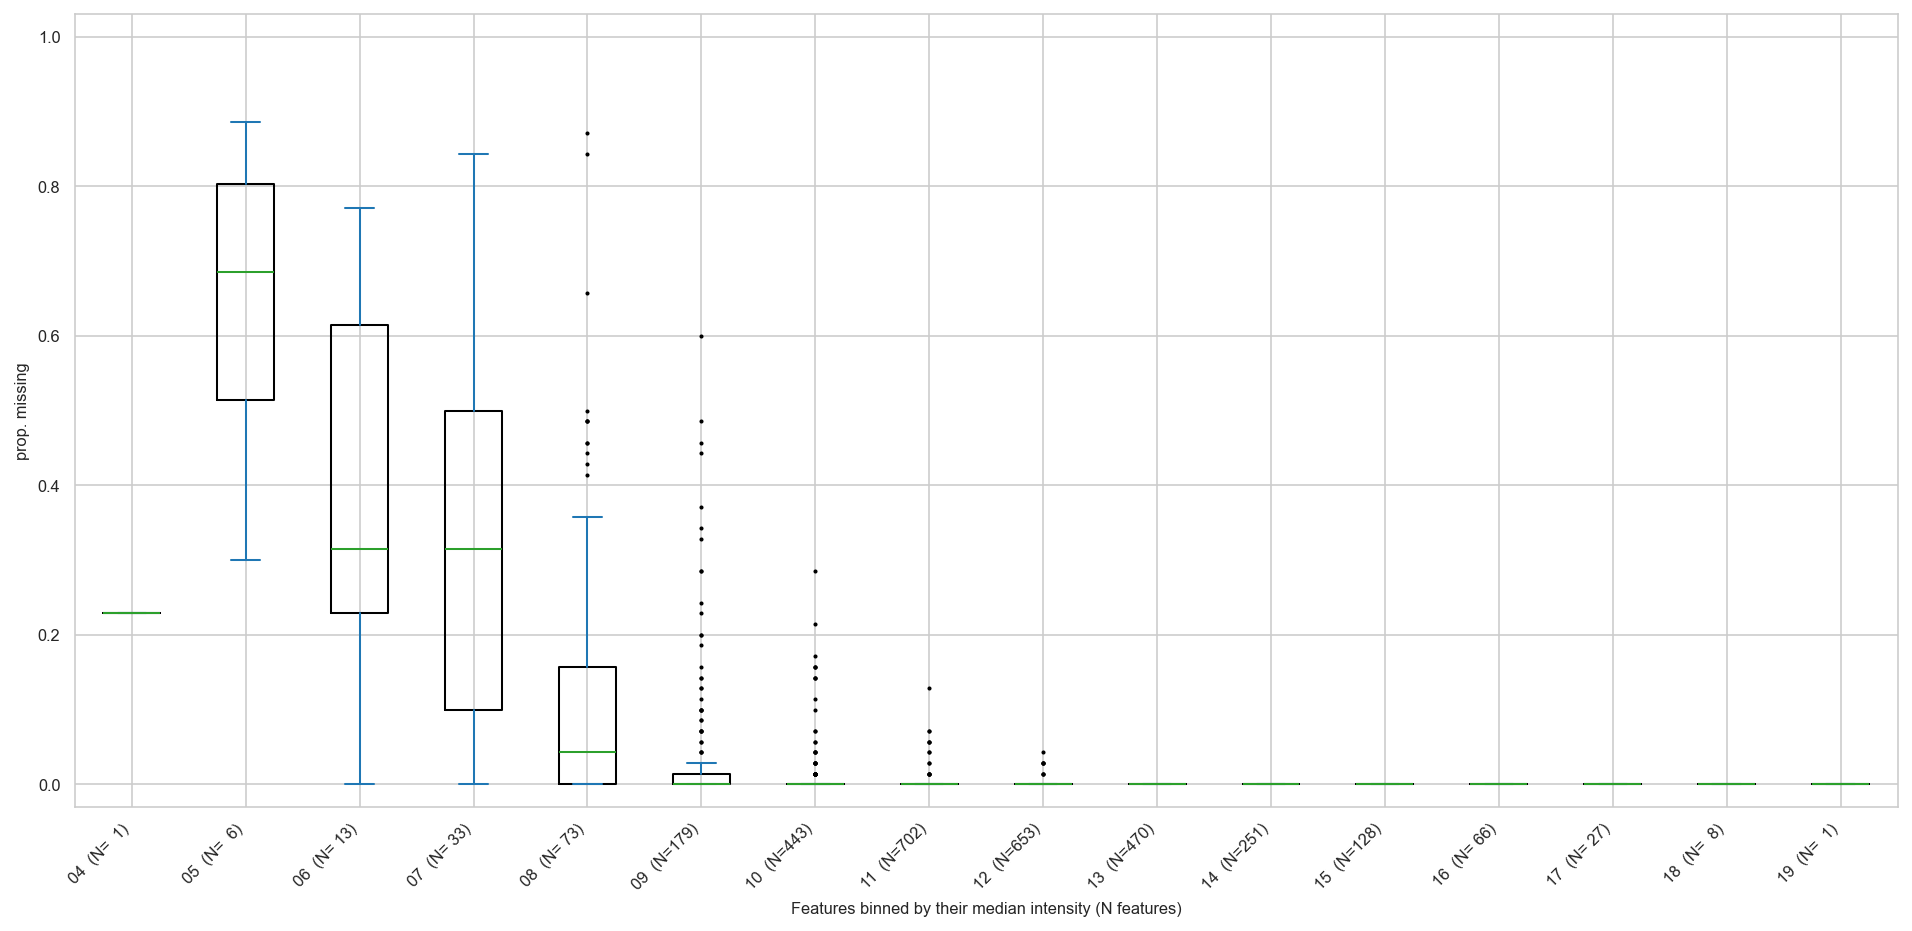

In [14]:
ax = pmp.data.plot_feat_median_over_prop_missing(data=df, type="boxplot")

### Robust missing value imputation


In [15]:
df = df.stack().to_frame("intensity")

splits, thresholds, fake_na_mcar, fake_na_mnar = pms.sample_mnar_mcar(
    df_long=df,
    frac_non_train=frac_non_train,
    frac_mnar=frac_mnar,
    random_state=random_state,
)
splits = pms.check_split_integrity(splits)

/Users/jl/.local/share/virtualenvs/msmu-c3VCzU_G/lib/python3.13/site-packages/pimmslearn/sampling.py:209: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  loc=float(quantile_frac),
/Users/jl/.local/share/virtualenvs/msmu-c3VCzU_G/lib/python3.13/site-packages/pimmslearn/sampling.py:210: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  scale=float(0.3 * df_long.std()),


suggested_lr.valley = 0.00174


epoch,train_loss,valid_loss,time
0,6.485989,6.509747,00:00
1,6.251815,5.976045,00:00
2,5.460804,4.372587,00:00
3,3.872555,2.426260,00:00
4,2.709371,2.012922,00:00
5,2.180454,1.923195,00:00
6,1.925208,1.871848,00:00
7,1.764576,1.779215,00:00
8,1.636816,1.668777,00:00
9,1.509906,1.566523,00:00


CollaborativeFilteringTransformer(item_column='protein group',
                                  out_folder=Path('runs/scikit_interface'),
                                  sample_column='Sample ID',
                                  target_column='intensity')

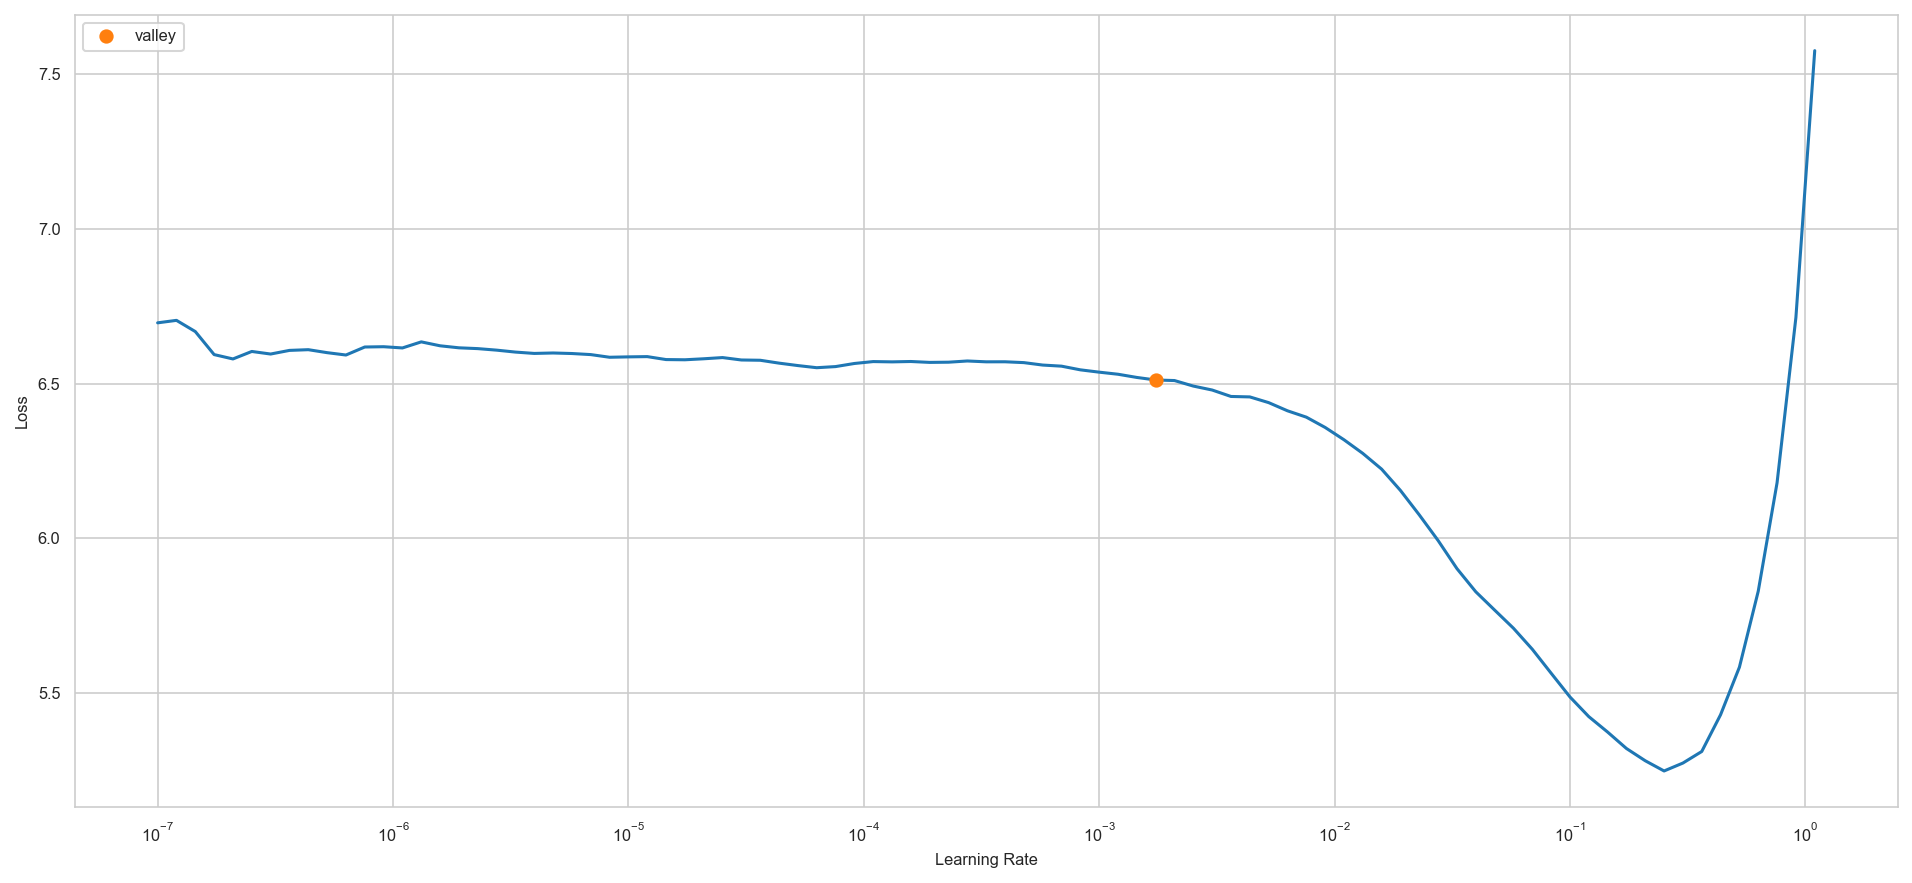

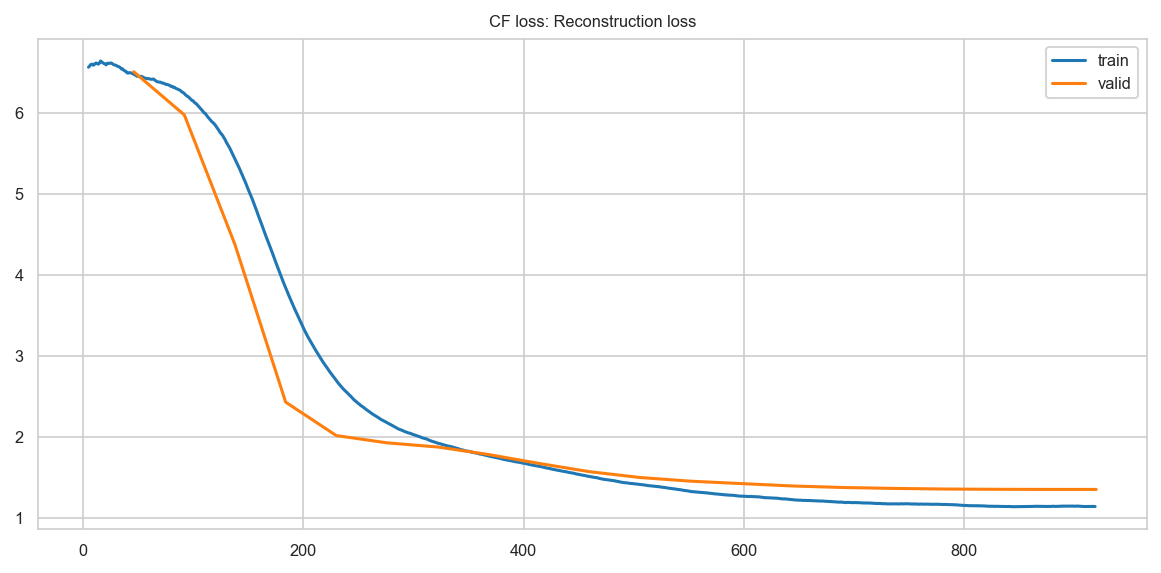

In [16]:
cf_model = CollaborativeFilteringTransformer(
    target_column="intensity",
    sample_column="Sample ID",
    item_column="protein group",
    out_folder="runs/scikit_interface",
)

cf_model.fit(splits.train_X, splits.val_y, cuda=False, epochs_max=20)

In [17]:
df_imputed = cf_model.transform(df).unstack()
assert df_imputed.isna().sum().sum() == 0

### Check imputation results


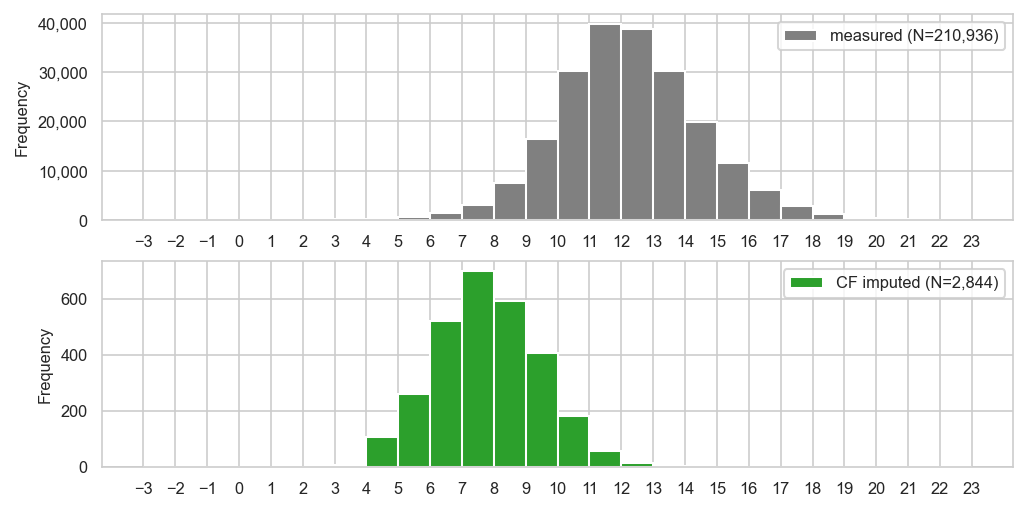

In [18]:
df_imputed = df_imputed.stack()  # long-format
observed = df_imputed.loc[df.index]
imputed = df_imputed.loc[df_imputed.index.difference(df.index)]
df_imputed = df_imputed.unstack()  # back to wide-format
# some checks
assert len(df) == len(observed)
assert df_imputed.shape[0] * df_imputed.shape[1] == len(imputed) + len(observed)

fig, axes = plt.subplots(2, figsize=(8, 4))

min_max = pmp.data.get_min_max_iterable([observed, imputed])
label_template = "{method} (N={n:,d})"
ax, _ = pmp.data.plot_histogram_intensities(
    observed,
    ax=axes[0],
    min_max=min_max,
    label=label_template.format(
        method="measured",
        n=len(observed),
    ),
    color="grey",
    alpha=1,
)
_ = ax.legend()
ax, _ = pmp.data.plot_histogram_intensities(
    imputed,
    ax=axes[1],
    min_max=min_max,
    label=label_template.format(
        method="CF imputed",
        n=len(imputed),
    ),
    color=color_model_mapping["CF"],
    alpha=1,
)
_ = ax.legend()

In [19]:
splits.to_wide_format()
splits.val_y = pd.DataFrame(pd.NA, index=splits.train_X.index, columns=splits.train_X.columns).fillna(splits.val_y)

### Imputation with denoising autoencoder


In [20]:
model_selected = "DAE"

model = AETransformer(
    model=model_selected,
    hidden_layers=[512],
    latent_dim=50,
    out_folder="runs/scikit_interface",
    batch_size=10,
)

epoch,train_loss,valid_loss,time
0,31026.431641,1674.701050,00:00
1,29505.796875,1574.615967,00:00
2,27473.275391,1364.723511,00:00
3,25387.703125,1461.137329,00:00
4,23851.017578,1340.688110,00:00
5,22549.154297,1254.133423,00:00
6,21466.306641,1270.100342,00:00
7,20491.173828,1219.311646,00:00
8,19528.302734,1248.465332,00:00
9,18762.316406,1288.510254,00:00


AETransformer(batch_size=10, hidden_layers=[512], latent_dim=50,
              model=<class 'pimmslearn.models.ae.Autoencoder'>,
              out_folder=Path('runs/scikit_interface'))

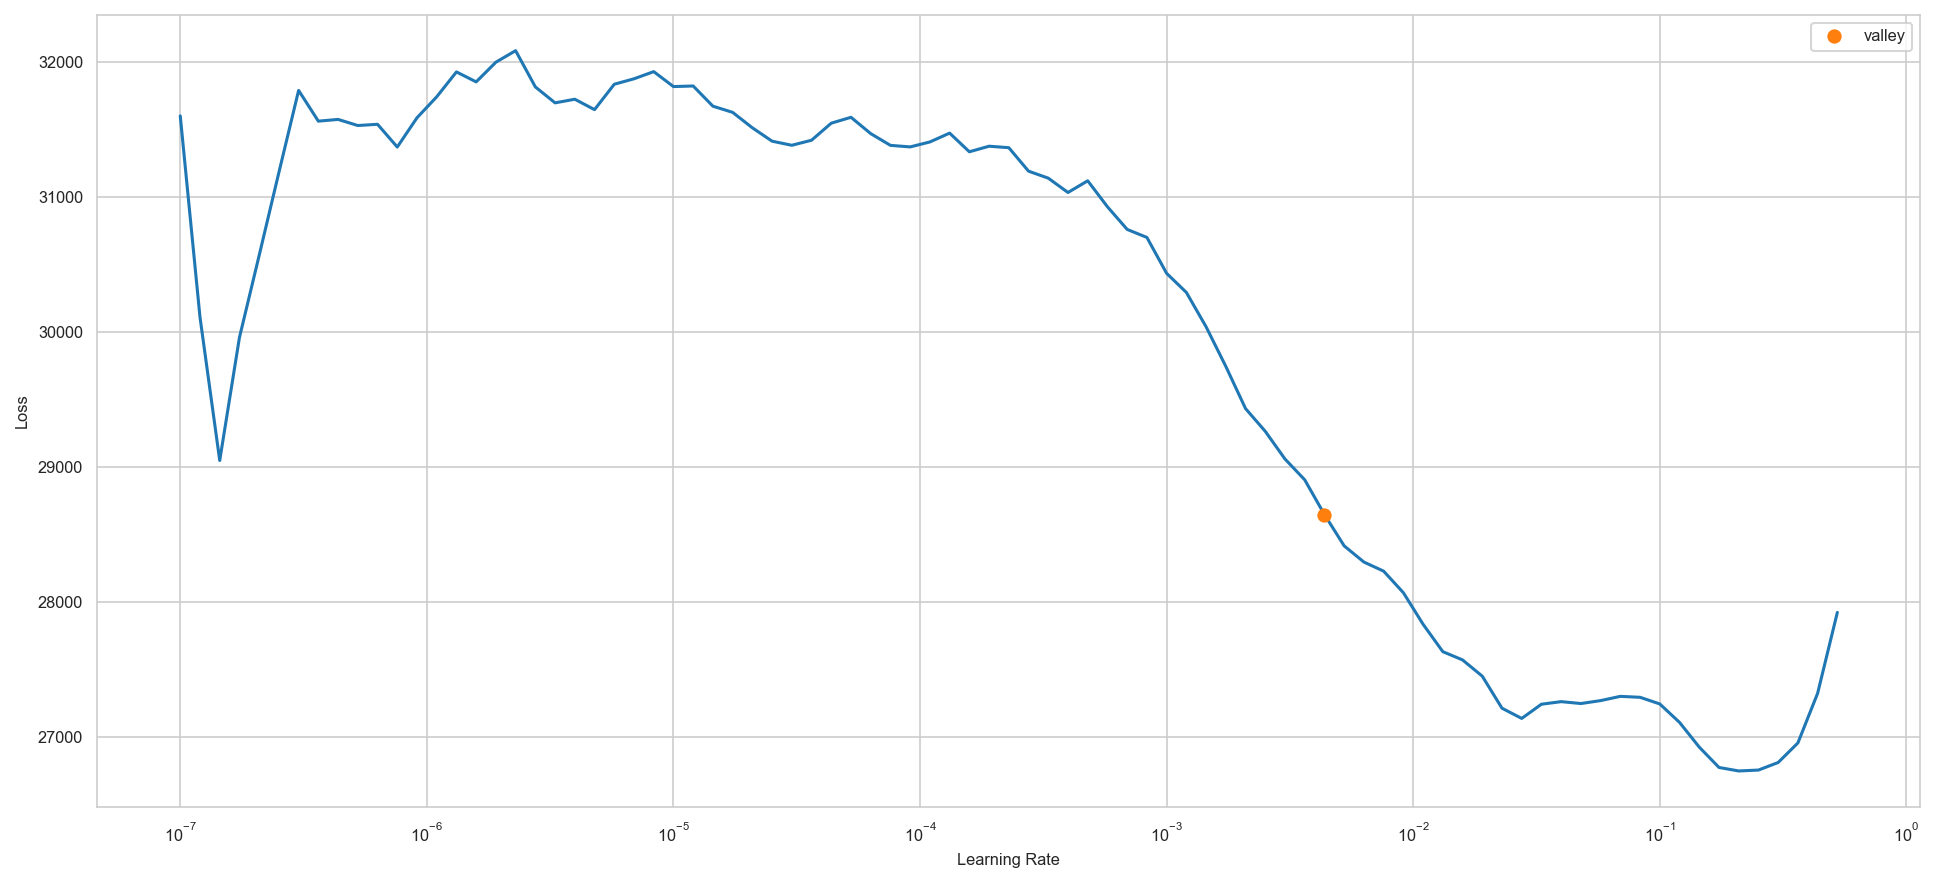

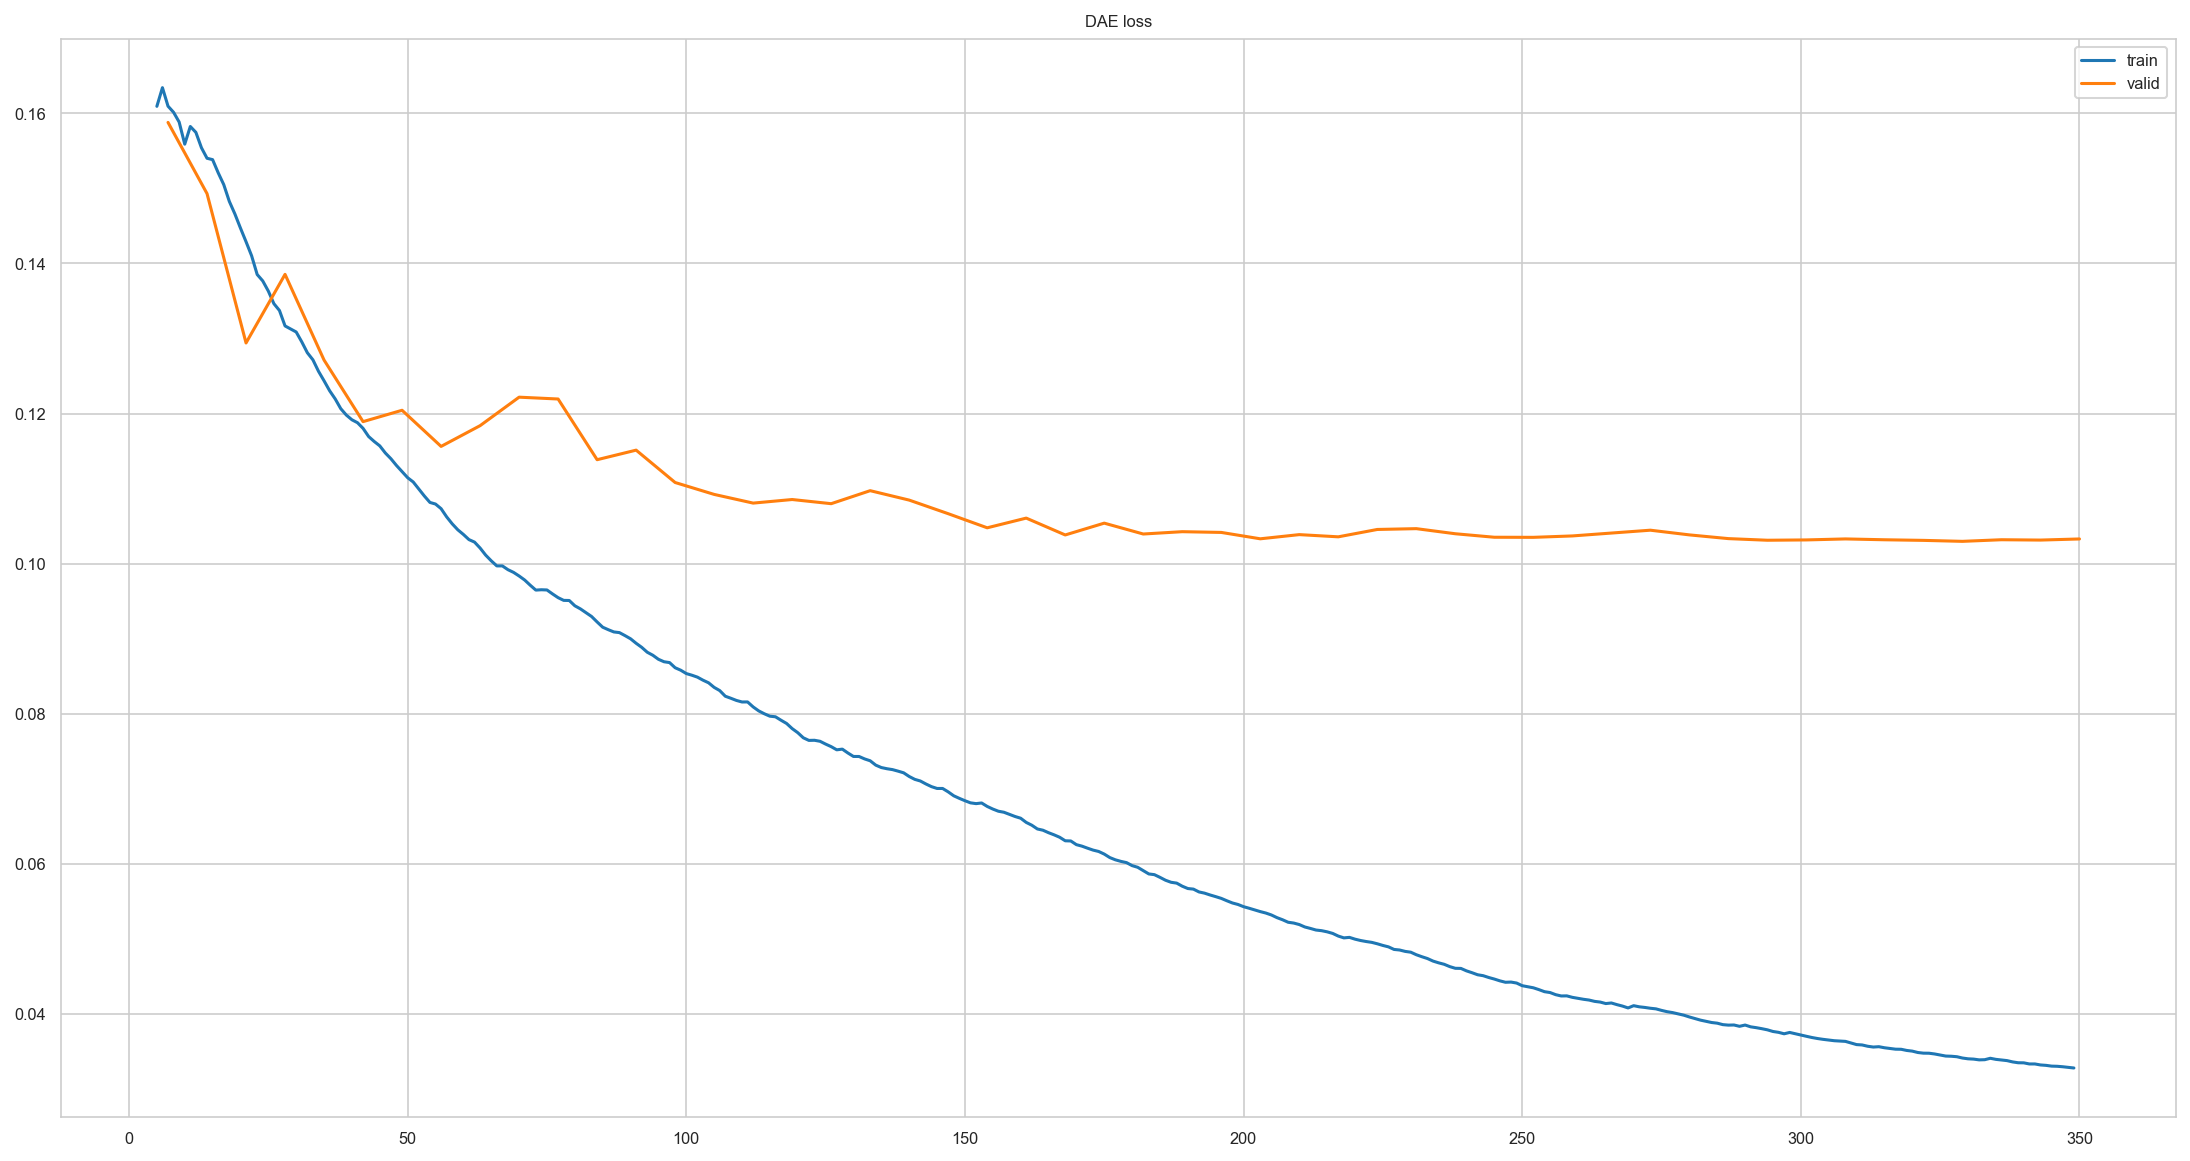

In [21]:
model.fit(splits.train_X, splits.val_y, epochs_max=50, cuda=False)

In [22]:
df_imputed = model.transform(splits.train_X).stack()

{'DAE': {'MSE': 1.2231082916259766,
  'MAE': 0.7873519659042358,
  'N': 10546,
  'prop': 1.0}}

/Users/jl/.local/share/virtualenvs/msmu-c3VCzU_G/lib/python3.13/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jl/.local/share/virtualenvs/msmu-c3VCzU_G/lib/python3.13/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


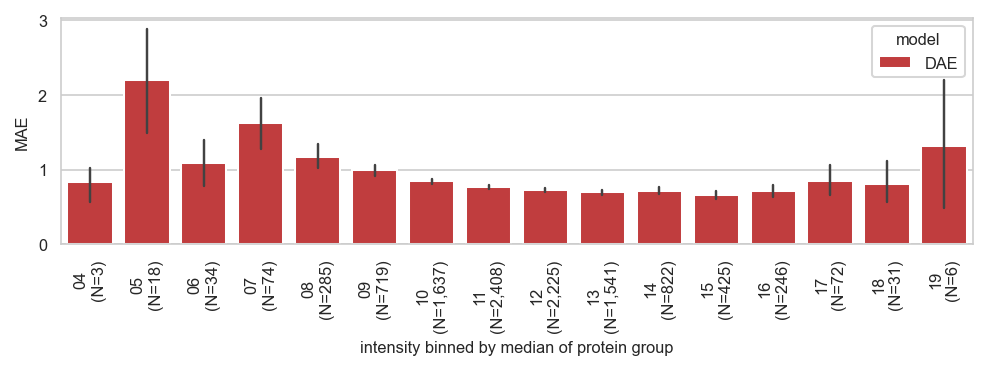

In [ ]:
pred_val = splits.val_y.stack().to_frame("observed")
pred_val[model_selected] = df_imputed
val_metrics = pmm.calculte_metrics(pred_val, "observed")

fig, ax = plt.subplots(figsize=(8, 2))

ax, errors_binned = pmp.errors.plot_errors_by_median(
    pred=pred_val,
    target_col="observed",
    feat_medians=splits.train_X.median(),
    ax=ax,
    metric_name="MAE",
    palette=color_model_mapping,
)

In [24]:
splits.to_long_format()
df_imputed = df_imputed.replace(splits.val_y).replace(splits.test_y)

### Check imputation results


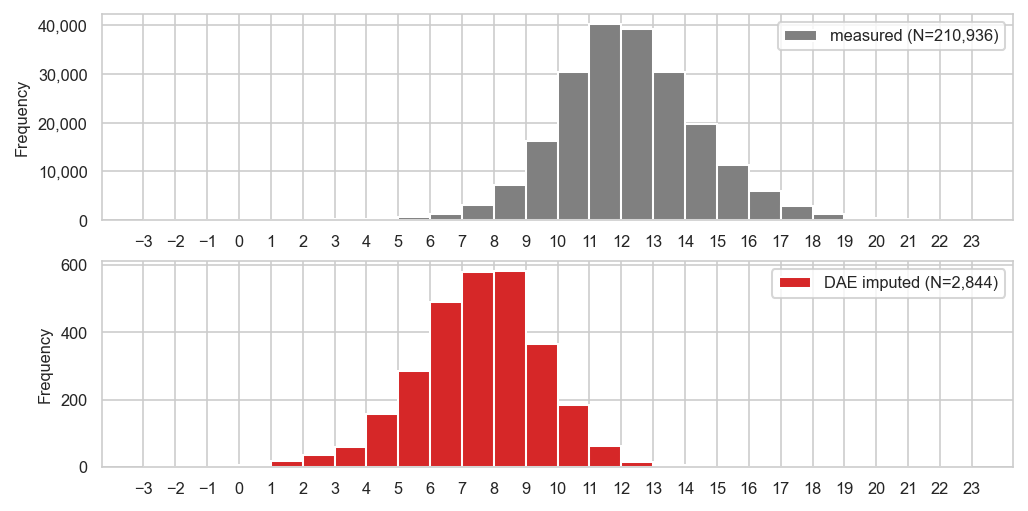

In [25]:
observed = df_imputed.loc[df.index].squeeze()
imputed = df_imputed.loc[df_imputed.index.difference(df.index)].squeeze()

fig, axes = plt.subplots(2, figsize=(8, 4))

min_max = pmp.data.get_min_max_iterable([observed, imputed])

label_template = "{method} (N={n:,d})"
ax, _ = pmp.data.plot_histogram_intensities(
    observed,
    ax=axes[0],
    min_max=min_max,
    label=label_template.format(
        method="measured",
        n=len(observed),
    ),
    color="grey",
    alpha=1,
)
_ = ax.legend()
ax, _ = pmp.data.plot_histogram_intensities(
    imputed,
    ax=axes[1],
    min_max=min_max,
    label=label_template.format(
        method=f"{model_selected} imputed",
        n=len(imputed),
    ),
    color=color_model_mapping[model_selected],
    alpha=1,
)
_ = ax.legend()

### Push imputed data to mudata object


In [26]:
mdata.mod["protein"].layers["imputed"] = df_imputed.unstack()
mdata.update()

mdata

/var/folders/pp/7ts5fh4x5hl81rnn895l34ph0000gn/T/ipykernel_85608/3088553350.py:1: ImplicitModificationWarning: Setting element `.layers['imputed']` of view, initializing view as actual.
  mdata.mod["protein"].layers["imputed"] = df_imputed.unstack()


MuData object with n_obs × n_vars = 70 × 95925
  obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
  uns:	'_cmd'
  3 modalities
    psm:	70 x 74025
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value', 'cell'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
      layers:	'raw'
    peptide:	70 x 18846
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value', 'protein_group', 'peptide_type'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'
    protein:	70 x 3054
      obs:	'set', 'sample', 'cell', 'condition', 'sample_rna'
      var:	'count_psm', 'count_stripped_peptide', 'PEP', 'q_value'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'
      layers:	'imputed'

## Saving MuData object


In [27]:
mdata.write_h5mu("02_MSV000089280.h5mu")